In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install -q tensorflow==1.13.1
!pip install -q pprint

In [0]:
import sys
sys.path.append('/content/drive/My Drive/GColab')

In [4]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [0]:
# seeds for reproducibility
from numpy.random import seed
seed(1337)
from tensorflow import set_random_seed
set_random_seed(1337)

import numpy as np

# tensorflow properties
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

# to implement functions at certain learning steps e.g. record weights
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import EarlyStopping

# imports from other files
import Callbacks
import model_selection
import data_selection
import classes
import plotting
import util
import info_plane
import early_stop_plotting
import Jupyter_popups

# NN Pruning
this notebook investigates if the clustering in the IP can be used for NN pruning. The last cell holds a guide for running this notebook

## Load Data

In [6]:
set_name = "tishby"

nrs = [3,8,1]
samples = 1000
seed(1337)
set_random_seed(1337)
X_train, X_test, y_train, y_test = data_selection.select_data(set_name, shuffle=True,
                                                              samples_per_class = samples,
                                                              list_of_nrs=nrs
                                                             )

Loading tishby Data...


## Create Classes, Define model and train it

##### set parameters like batch, size learning rate... 

In [0]:
# object to record parameters
outputs = classes.Outputs()

In [0]:
nr_of_tot_epochs = 8000
nr_of_epochs = 8000
batch = 256
learning_r = [0.0004]

##### Set flags

In [0]:
# record all epochs or reduced amount
record_all_flag = False
# record intermediate test scores
rec_test_flag = True
# save data and plots and show plots
save_data_flag = False
save_MI_and_plots = True
show_flag=True

stop_early = True
perf_stop = False

In [10]:
# model 1 = model with leading ReLU
# model 2 = model with leading TanH
# model 3 = full ReLU
# model 4 = full TanH
# ...
seed(1337)
set_random_seed(1337)
model_nr = 13
model, architecture = model_selection.select_model(model_nr, nr_of_epochs,
                                                   set_name, X_train.shape, y_train)

amount of classes 2
Input shape:  (3276, 12)  length:  2
Instructions for updating:
Colocations handled automatically by placer.


##### define callback function

In [0]:
# call callback functions
output_recording = LambdaCallback(on_epoch_end=lambda epoch,
                                   logs: Callbacks.record_activations(outputs, model, epoch,
                                                               X_train, X_test, y_test, batch,
                                                               record_all_flag, rec_test_flag,
                                                               specific_records=[nr_of_epochs-1]))
early_stopp = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

callback returns matrix with n arrays where n is the number of features and each array has m elements where m is the number of neurons

##### train model

In [12]:
adam = optimizers.Adam(lr=learning_r)
model.compile(loss="categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])
seed(1337)
set_random_seed(1337)
if stop_early == True:
    history = model.fit(X_train, y_train, epochs=nr_of_epochs, batch_size=batch,
                        validation_split=0.2, callbacks = [output_recording, early_stopp])
else:
    history = model.fit(X_train, y_train, epochs=nr_of_epochs, batch_size=batch,
                        validation_split=0.2, callbacks = [output_recording])


Train on 2620 samples, validate on 656 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/8000
2620/2620 [==============================] - 0s 184us/sample - loss: 0.6920 - acc: 0.5267 - val_loss: 0.6916 - val_acc: 0.5351
Epoch 2/8000
2620/2620 [==============================] - 0s 57us/sample - loss: 0.6915 - acc: 0.5267 - val_loss: 0.6911 - val_acc: 0.5351
Epoch 3/8000
2620/2620 [==============================] - 0s 51us/sample - loss: 0.6911 - acc: 0.5267 - val_loss: 0.6905 - val_acc: 0.5351
Epoch 4/8000
2620/2620 [==============================] - 0s 52us/sample - loss: 0.6906 - acc: 0.5267 - val_loss: 0.6899 - val_acc: 0.5351
Epoch 5/8000
2620/2620 [==============================] - 0s 52us/sample - loss: 0.6900 - acc: 0.5267 - val_loss: 0.6892 - val_acc: 0.5351
Epoch 6/8000
2620/2620 [==============================] - 0s 54us/sample - loss: 0.6894 - acc: 0.5267 - val_loss: 0.6883 - val_acc: 0.5351
Epoch 7/8000
2620/2620 [==============================] - 0s 52us/samp

# Information Plane creation

### helper functions

In [0]:
def name_creation(architecture, learning_r, batch, stop_early, perf_stop):
    """
    creates architecture name
    """
    if stop_early == True:
        common_name = "early_stop_" + architecture + "_lr_" + str(learning_r) + "_batchsize_" + str(batch)
    elif perf_stop == True:
        common_name = "perfect_stop_" + architecture + "_lr_" + str(learning_r) + "_batchsize_" + str(batch)
    else:
        common_name = "no_early_stop_" + architecture + "_lr_" + str(learning_r) + "_batchsize_" + str(batch)
    return common_name

def extract_max_key(MI_dic):
    """
    find keys of max mi
    """
    max_key = max(MI_dic, key=MI_dic.get)
    return max_key

def extract_max(MI_object):
    """
    find maximum MI values
    """
    max_x = MI_object.mi_x[extract_max_key(MI_object.mi_x)]
    max_y = MI_object.mi_y[extract_max_key(MI_object.mi_y)]
    return max_x, max_y

##### create model name and define colours for plots

In [0]:
common_name = name_creation(architecture, learning_r, batch, stop_early, perf_stop)
if "mnist" in set_name:
    common_name = str(samples) + str(nrs) + common_name
    
color_list = ["red", "blue", "green", "orange", "purple",
                   "brown", "gray", "teal", "goldenrod", "pink", "limegreen",
                   "cornflowerblue", "black"]

##### find model score and potentially safe data

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)[1]

aname = common_name + "_activations"
outputs.model_score = score
if save_data_flag == True:
    util.save(outputs, aname)

hname = common_name + "_history"
h_obj = history.history
h_obj["model_score"] = score
if save_data_flag == True:
    util.save(h_obj, hname)



##### loss and test score plots

creating history plot


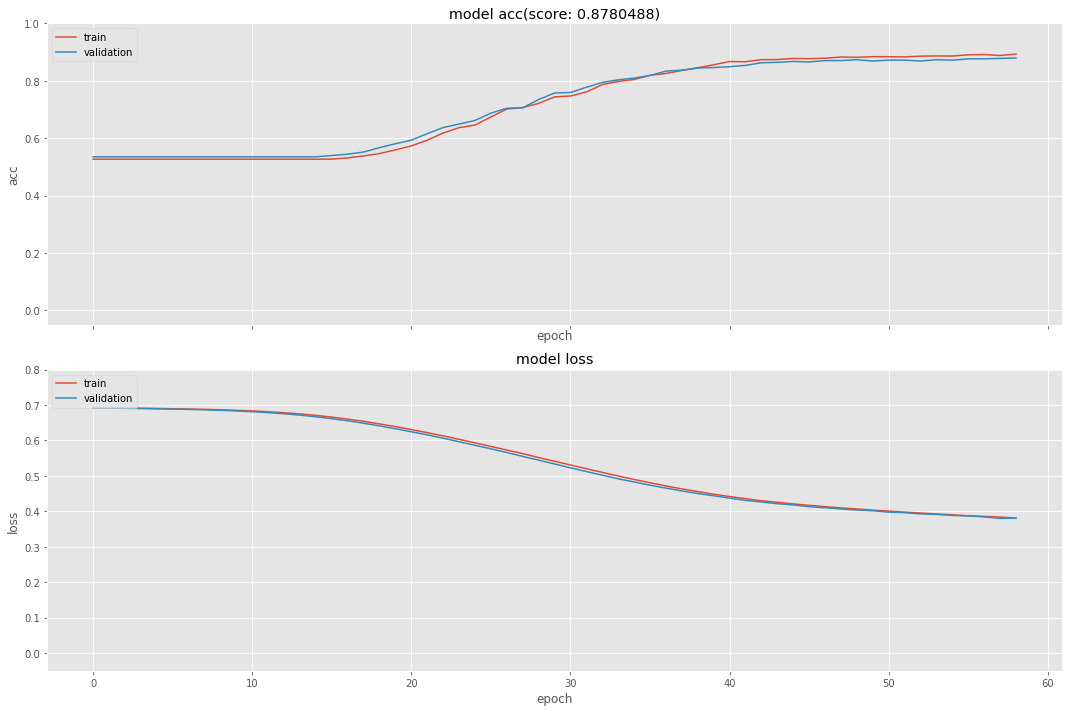

In [16]:
plotting.plot_history(h_obj, common_name, show_flag, save_MI_and_plots)

creating testscore devolopment plot


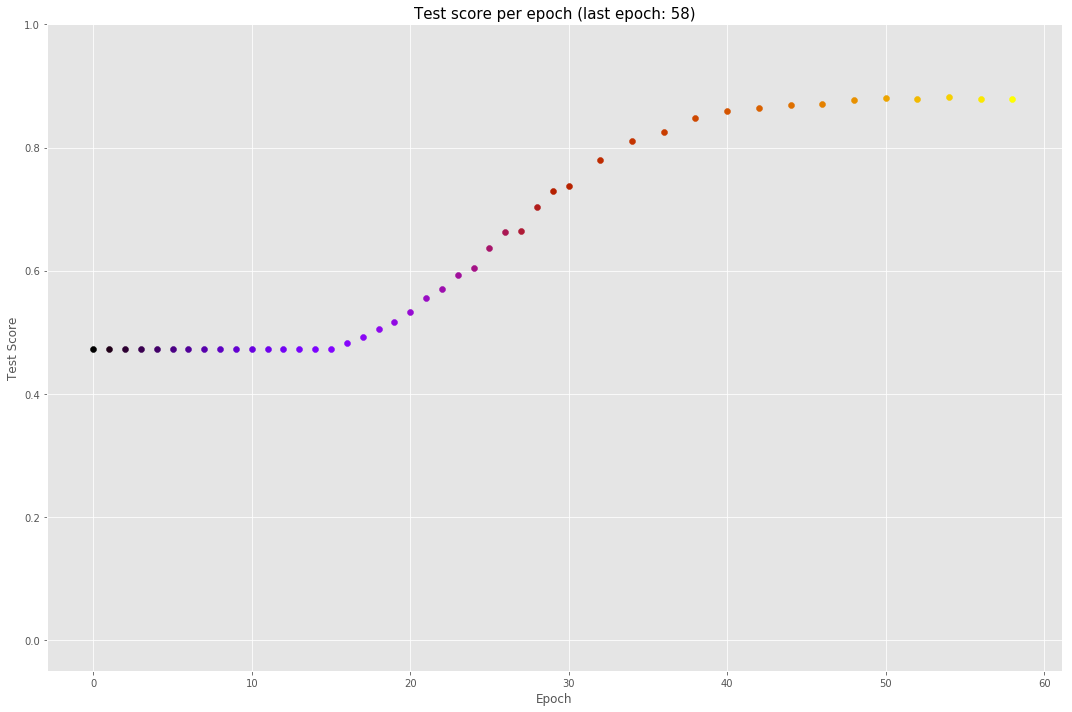

In [17]:
plotting.plot_test_development(outputs.int_model_score, common_name, show_flag,
                               save_MI_and_plots)

## Mutual information calculation

##### in this section the maximum values of the mutual information have to be noted down after a run with the maximum epochs for early stop and to have the same maximum plot values
##### this has to be done with all the estimators that are used and safed in the cells before the estimators

### Binning

In [0]:
bin_max_mi = [11.677719641641012, 0.9976734295143714]

o max:  {0: 3.1855948, 1: 5.5081096, 2: 6.3705254, 3: 5.6343703, 4: 5.64143, 5: 5.159195, 6: 6.799325, 7: 10.072148, 8: 10.101073, 9: 10.010287, 10: 11.349997, 11: 0.9999783}
o min:  {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 2.171369e-05}
X and Y MI:  0.9976734295143714 , X Entropy:  11.677719641641012
MI for epoch  0  is being calculated for  0.07  bins
MI for epoch  1  is being calculated for  0.07  bins
MI for epoch  2  is being calculated for  0.07  bins
MI for epoch  3  is being calculated for  0.07  bins
MI for epoch  4  is being calculated for  0.07  bins
MI for epoch  5  is being calculated for  0.07  bins
MI for epoch  6  is being calculated for  0.07  bins
MI for epoch  7  is being calculated for  0.07  bins
MI for epoch  8  is being calculated for  0.07  bins
MI for epoch  9  is being calculated for  0.07  bins
MI for epoch  10  is being calculated for  0.07  bins
MI for epoch  11  is being calculated for  0.07  bins
MI for

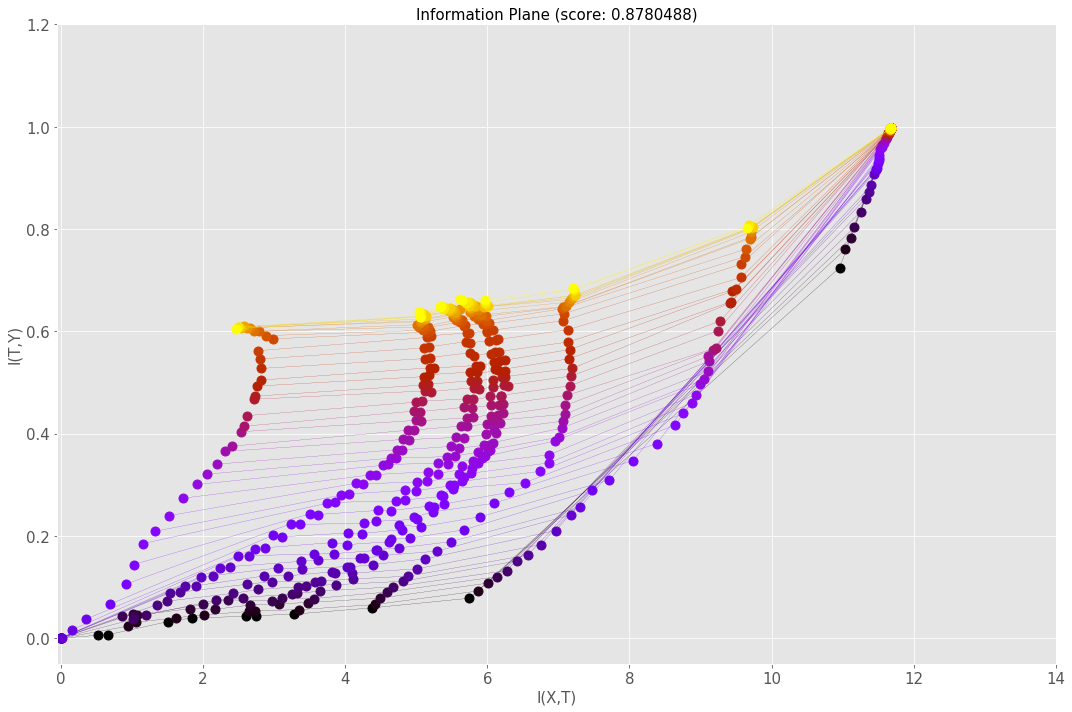

Creating layerview plot


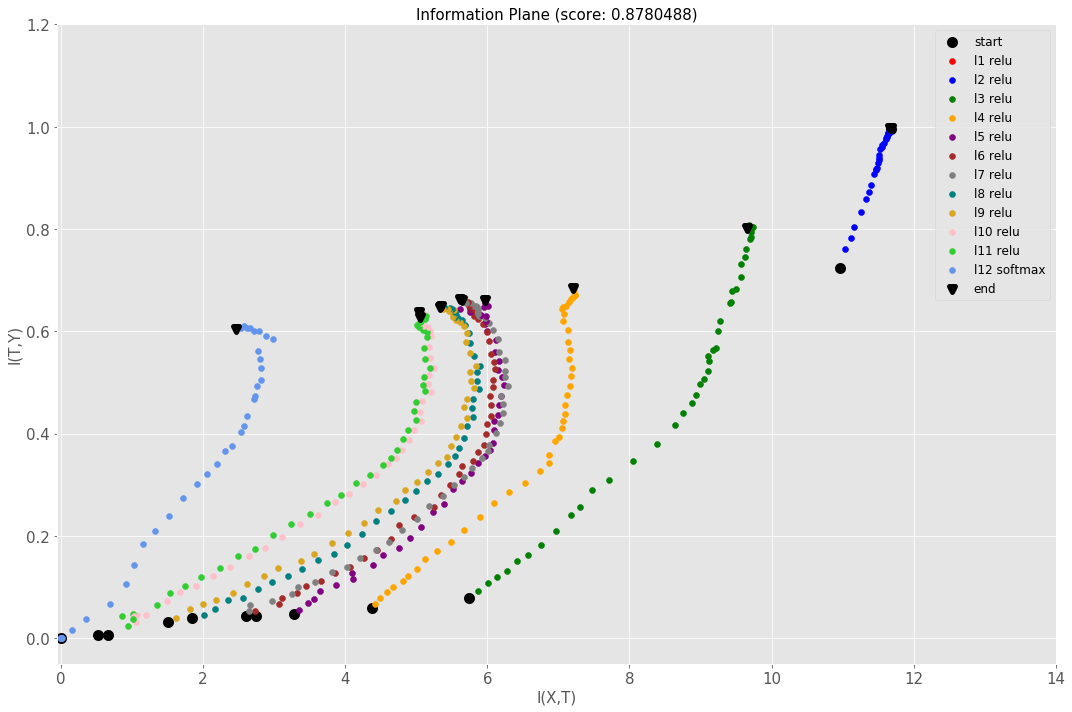

Creating combinationview plot


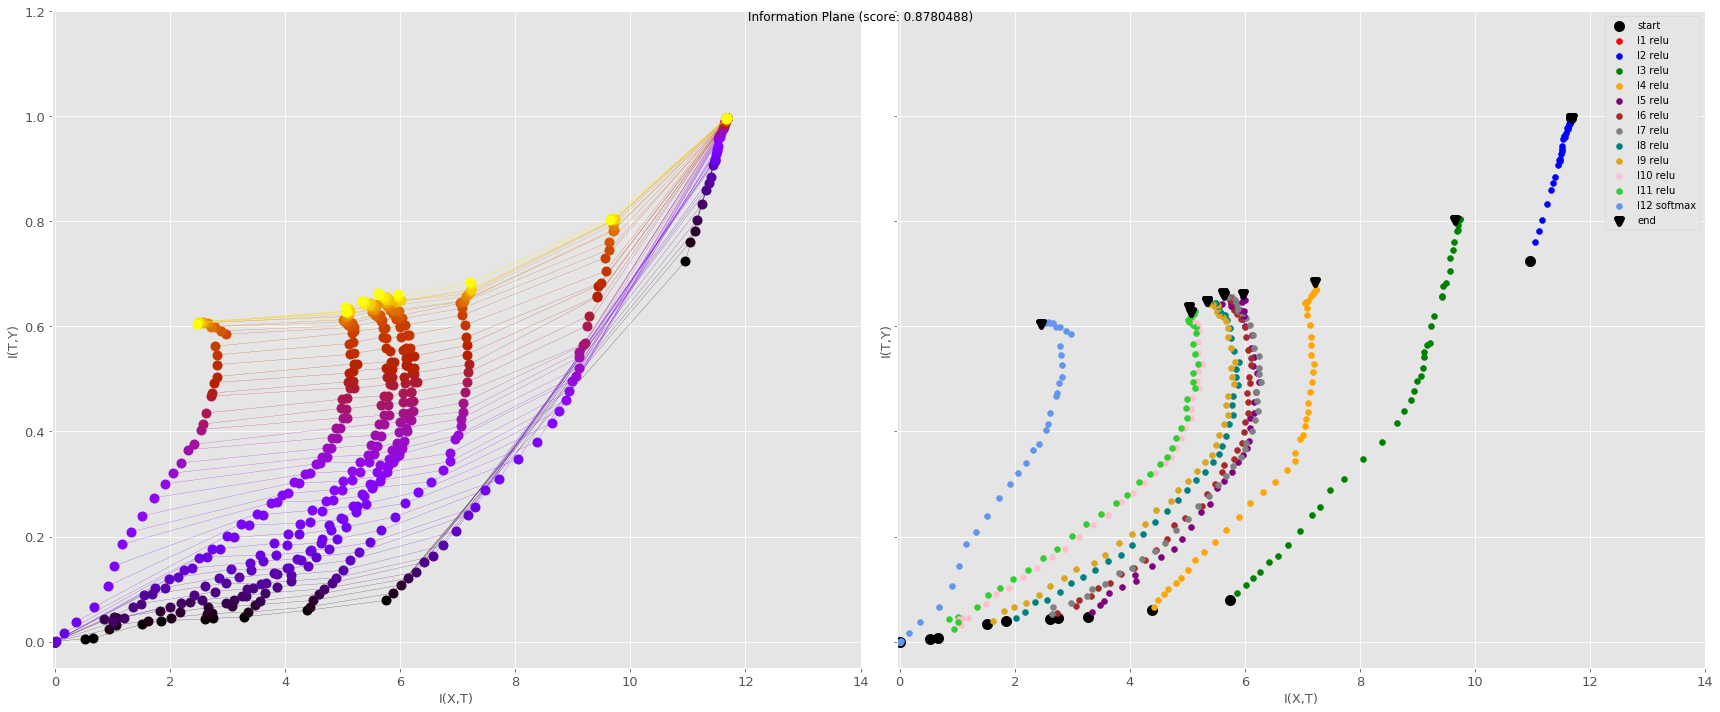

In [19]:
est_type_flag = 1
bin_amount = 0.07
bin_size_or_nr=True
separate_flag = False

seed(1337)
set_random_seed(1337)

BMI_object = classes.Binning_MI()
if perf_stop == False and stop_early == False:
    full_flag = True
    BMI_object = info_plane.create_infoplane(common_name, X_train, y_train, outputs,
                                             est_type_flag, color_list, bin_amount,
                                             bin_size_or_nr, show_flag, separate_flag,
                                             save_MI_and_plots, False)
    # note these values for next execution and fill into bin_max_mi line 7 of this cell
    bin_max_vals = extract_max(BMI_object)
    print("maximum values for MI with X and Y", bin_max_vals)
    
else:
    full_flag = False
    BMI_object = info_plane.ranged_create_infoplane(bin_max_mi[0], bin_max_mi[1], common_name, X_train,
                                       y_train, outputs, est_type_flag, color_list,
                                       bin_amount, bin_size_or_nr, show_flag, separate_flag,
                                                    save_MI_and_plots, False)

## ReLU
The big ReLU model (13) stops after 58 iterations with a score of 0.8780.
L5, L6 and L7 as well as L8 and L9 as well as L10 and L11 have very similar trajectories so lets try to prune 2 of the first group and one of each of the others.
-> change model nr to 15 and run again
This results in model score of ~0.8646 after 112 epochs. Looking at the IP we see that L5, L6 and L7 have very similar trajectories so lets prun 2 of them
-> we reach back to the model where no repeating layers of same size are included run model 3 leading to a score of 0.8805 after 78 epochs

## TanH
For the Big TanH network (12) reaches a score of 0.8768 after 42 epochs. L5, L6 and L7 are very similar so lets prune 2 of them. -> this model (14) reaches 0.8780 after 50 epochs. Again L5, L6 and L7 are very similar lets prune 2 more -> this model (16) reaches 0.8732 after 50 epochs and again L5, L6 and L7. If we prune them one more time we reach the original configuration without additional same size layers with a score of 0.8805 after 58 epochs